# ResNet50迁移学习

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/application/zh_cn/cv/mindspore_transfer_learning.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/application/zh_cn/cv/mindspore_transfer_learning.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/application/source_zh_cn/cv/transfer_learning.ipynb)

在实际应用场景中，由于训练数据集不足，所以很少有人会从头开始训练整个网络。普遍的做法是，在一个非常大的基础数据集上训练得到一个预训练模型，然后使用该模型来初始化网络的权重参数或作为固定特征提取器应用于特定的任务中。本章将使用迁移学习的方法对ImageNet数据集中的狼和狗图像进行分类。

> 迁移学习详细内容见[Stanford University CS231n](https://cs231n.github.io/transfer-learning/#tf)

## 数据准备

### 下载数据集

下载案例所用到的[狗与狼分类数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip)，数据集中的图像来自于ImageNet，每个分类有大约120张训练图像与30张验证图像。使用`mindvision.dataset.DownLoad`接口下载数据集，并将下载后的数据集自动解压到当前目录下。

In [1]:
from mindvision.dataset import DownLoad

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip"
path = "./"

dl = DownLoad()
dl.download_and_extract_archive(dataset_url, path)

数据集的目录结构如下：

```Text
data/
└── Canidae
    ├── train
    │   ├── dogs
    │   └── wolves
    └── val
        ├── dogs
        └── wolves
```

## 加载数据集

狼狗数据集提取自ImageNet分类数据集，使用`mindvision.dataset.ImageNet`接口来加载数据集，此接口已对ImageNet分类数据集中的图像做了默认的图像增强操作。

In [2]:
from mindvision.dataset import ImageNet

# 数据集目录路径
data_path = "./data/Canidae/"

# 创建训练数据集
dataset_train = ImageNet(data_path, split="train", shuffle=True,
                         resize=224, batch_size=18, repeat_num=1)
dataset_train = dataset_train.run()

# 创建评估数据集
dataset_val = ImageNet(data_path, split="val", shuffle=True,
                       resize=224, batch_size=18, repeat_num=1)
dataset_val = dataset_val.run()

### 数据集可视化

从`mindvision.dataset.ImageNet`接口中加载的训练数据集返回值为字典，用户可通过 `create_dict_iterator` 接口创建数据迭代器，使用 `next` 迭代访问数据集。本章中 `batch_size` 设为18，所以使用 `next` 一次可获取18个图像及标签数据。

In [3]:
data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

Tensor of image (18, 3, 224, 224)
Labels: [1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0]


对获取到的图像及标签数据进行可视化，标题为图像对应的label名称。

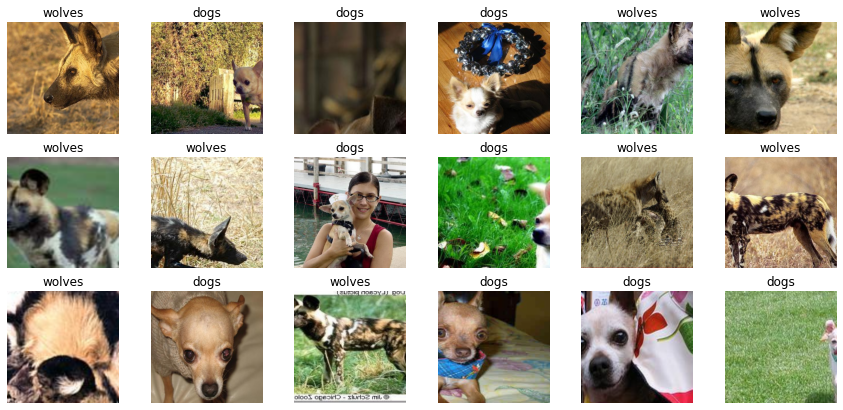

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# class_name对应label，按文件夹字符串从小到大的顺序标记label
class_name = {0: "dogs", 1: "wolves"}

plt.figure(figsize=(15, 7))
for i in range(len(labels)):
    # 获取图像及其对应的label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # 处理图像供展示使用
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # 显示图像
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

## 训练模型

本章使用ResNet50模型进行训练。使用MindSpore Vision中的`mindvision.classification.models.resnet50`接口定义ResNet50网络，当接口中的`pretrained`参数设置为True时，可以自动下载[ResNet50的预训练模型](https://download.mindspore.cn/vision/classification/resnet50_224.ckpt)并将权重参数加载到网络中。

### 模型微调

由于ResNet50中的预训练模型是针对ImageNet数据集中的1000个类别进行分类的，在本章只对狼和狗两个类别进行分类，所以需要重置预训练模型中的分类器，然后重新微调网络。

In [12]:
import mindspore.nn as nn
from mindvision.classification.models import resnet50
from mindspore import load_checkpoint, load_param_into_net
from mindspore import Model

net = resnet50(pretrained=True)

# 定义全连接层
class DenseHead(nn.Cell):
    def __init__(self, input_channel, num_classes):
        super(DenseHead, self).__init__()
        self.dense = nn.Dense(input_channel, num_classes)

    def construct(self, x):
        return self.dense(x)

# 全连接层输入层的大小
in_channels = net.head.dense.in_channels
# 输出通道数大小为狼狗分类数2
head = DenseHead(in_channels, 2)
# 重置全连接层
net.head = head

# 定义优化器和损失函数
opt = nn.Momentum(params=net.trainable_params(), learning_rate=0.001, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 实例化模型
model = Model(net, loss, opt, metrics={"Accuracy": nn.Accuracy()})

#### 训练和评估

训练并评估网络，使用MindSpore Vision中的 `mindvision.engine.callback.ValAccMonitor` 接口打印训练的损失值和评估精度，且在训练完成后，保存评估精度最高的ckpt文件(best.ckpt)到当前目录下。

In [6]:
from mindvision.engine.callback import ValAccMonitor
from mindspore import TimeMonitor

num_epochs = 10
model.train(num_epochs,
            dataset_train,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs), TimeMonitor()])

--------------------
Epoch: [  0 /  10], Train Loss: [0.469], Accuracy:  1.000
epoch time: 6525.242 ms, per step time: 501.942 ms
--------------------
Epoch: [  1 /  10], Train Loss: [0.134], Accuracy:  1.000
epoch time: 2549.441 ms, per step time: 196.111 ms
--------------------
Epoch: [  2 /  10], Train Loss: [0.069], Accuracy:  1.000
epoch time: 2561.402 ms, per step time: 197.031 ms
--------------------
Epoch: [  3 /  10], Train Loss: [0.131], Accuracy:  1.000
epoch time: 2564.437 ms, per step time: 197.264 ms
--------------------
Epoch: [  4 /  10], Train Loss: [0.097], Accuracy:  1.000
epoch time: 2563.061 ms, per step time: 197.159 ms
--------------------
Epoch: [  5 /  10], Train Loss: [0.037], Accuracy:  1.000
epoch time: 2569.943 ms, per step time: 197.688 ms
--------------------
Epoch: [  6 /  10], Train Loss: [0.011], Accuracy:  1.000
epoch time: 2577.678 ms, per step time: 198.283 ms
--------------------
Epoch: [  7 /  10], Train Loss: [0.018], Accuracy:  1.000
epoch time:

#### 可视化模型预测

定义 `visualize_mode` 函数，可视化模型预测。

In [7]:
import matplotlib.pyplot as plt
from mindspore import Tensor


def visualize_model(best_ckpt_path, val_ds):
    num_class = 2  # 对狼和狗图像进行二分类
    net = resnet50(num_class)
    # 加载模型参数
    param_dict = load_checkpoint(best_ckpt_path)
    load_param_into_net(net, param_dict)
    model = Model(net)
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    class_name = {0: "dogs", 1: "wolves"}
    # 预测图像类别
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure(figsize=(15, 7))
    for i in range(len(labels)):
        plt.subplot(3, 6, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

使用模型微调得到的best.ckpt文件对验证集的狼和狗图像数据进行预测。若预测字体为蓝色表示预测正确，若预测字体为红色表示预测错误。

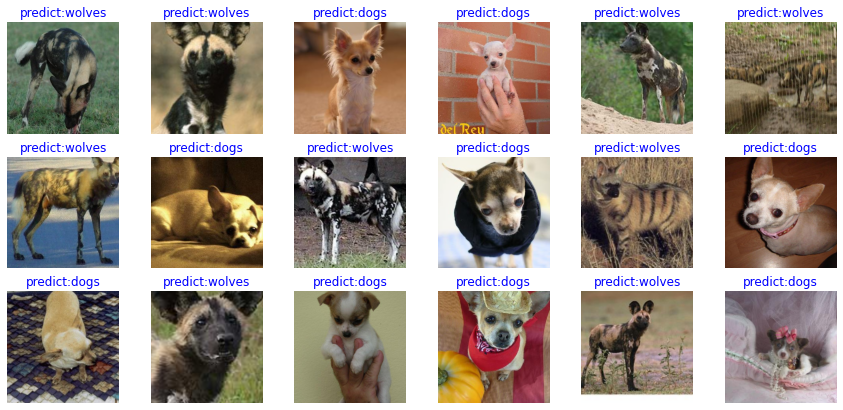

In [8]:
visualize_model('best.ckpt', dataset_val)

### 固定特征进行训练

使用固定特征进行训练的时候，需要冻结除最后一层之外的所有网络层。通过设置 `requires_grad == False` 冻结参数，以便不在反向传播中计算梯度。

In [9]:
import mindspore.nn as nn
from mindvision.classification.models import resnet50
from mindspore import load_checkpoint, load_param_into_net
from mindspore import Model

net_work = resnet50(pretrained=True)

# 全连接层输入层的大小
in_channels = net_work.head.dense.in_channels
# 输出通道数大小为狼狗分类数2
head = DenseHead(in_channels, 2)
# 重置全连接层
net_work.head = head

# 冻结除最后一层外的所有参数
for param in net_work.get_parameters():
    if param.name not in ["head.dense.weight", "head.dense.bias"]:
        param.requires_grad = False

# 定义优化器和损失函数
opt = nn.Momentum(params=net_work.trainable_params(), learning_rate=0.001, momentum=0.5)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 实例化模型
model1 = Model(net_work, loss, opt, metrics={"Accuracy": nn.Accuracy()})

#### 训练和评估

开始训练模型，与没有预训练模型相比，将节约一大半时间，因为此时可以不用计算部分梯度。

In [10]:
# 用于训练的数据集
from mindvision.engine.callback import ValAccMonitor
from mindspore import TimeMonitor

ds_train = ImageNet(data_path, split="train", shuffle=True,
                    resize=224, batch_size=18, repeat_num=1)
ds_train = ds_train.run()
ds_val = ImageNet(data_path, split="val", shuffle=True,
                  resize=224, batch_size=18, repeat_num=1)
ds_val = ds_val.run()

num_epochs = 10
model1.train(num_epochs,
             ds_train,
             callbacks=[ValAccMonitor(model1, ds_val, num_epochs), TimeMonitor()])

--------------------
Epoch: [  1 /  10], Train Loss: [0.598], Accuracy:  0.981
epoch time: 3602.971 ms, per step time: 277.152 ms
--------------------
Epoch: [  2 /  10], Train Loss: [0.516], Accuracy:  0.870
epoch time: 1422.890 ms, per step time: 109.453 ms
--------------------
Epoch: [  3 /  10], Train Loss: [0.388], Accuracy:  1.000
epoch time: 2254.670 ms, per step time: 173.436 ms
--------------------
Epoch: [  4 /  10], Train Loss: [0.362], Accuracy:  1.000
epoch time: 2181.150 ms, per step time: 167.781 ms
--------------------
Epoch: [  5 /  10], Train Loss: [0.332], Accuracy:  1.000
epoch time: 2173.812 ms, per step time: 167.216 ms
--------------------
Epoch: [  6 /  10], Train Loss: [0.306], Accuracy:  1.000
epoch time: 2205.381 ms, per step time: 169.645 ms
--------------------
Epoch: [  7 /  10], Train Loss: [0.285], Accuracy:  1.000
epoch time: 2180.671 ms, per step time: 167.744 ms
--------------------
Epoch: [  8 /  10], Train Loss: [0.244], Accuracy:  1.000
epoch time:

#### 可视化模型预测

使用固定特征得到的best.ckpt文件对对验证集的狼和狗图像数据进行预测。若预测字体为蓝色即为预测正确，若预测字体为红色则预测错误。

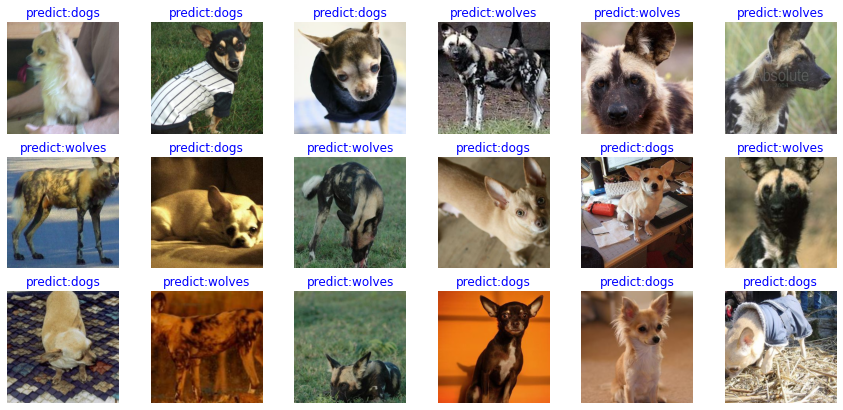

In [11]:
visualize_model('best.ckpt', dataset_val)